## Connect với drive 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AIC_HCM/DOLG/DOLG_New

/content/drive/.shortcut-targets-by-id/1m0rrLIYvPFV92b1Sh7VRMwu4Gyv4k4Vo/AIC_HCM/DOLG/DOLG_New


## Install Libraries

In [ ]:
# ### Install Environment
# !pip install timm
# !pip install faiss-gpu
# !pip install wandb
# !wandb login
# import wandb
# !wandb.init(project="Image_Retrieval")

## Download data 

In [ ]:
# !gdown --id 1ydH-yxL9341xLCe6GE1rw1SmoN_jpctO

In [ ]:
# !unzip data.zip

## import library 

In [ ]:
import numpy as np 
import pandas as pd 

import os 
import cv2 
import warnings
import timm 

from torchvision import transforms

import torch 
import torch.nn.functional as F 
from torch import nn 
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

from torch.utils.data import Dataset

import math

from tqdm.notebook import tqdm 
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

import copy
import random
from PIL import Image
import faiss
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import glob
import gc
import albumentations

## Xử lý data

In [ ]:
path_data = '/content/drive/MyDrive/AIC_HCM/DOLG/DOLG-pytorch/dataset/data/train'
def img_path_from_id(id):
    split_id = id.split("_")
    sub_folder = "_".join(split_id[:-1])
    img_path = os.path.join(path_data,
                            sub_folder, f'{id}.jpg')
    return img_path
class LmkRetrDataset(Dataset):
    def __init__(self, file_name):
        self.df = pd.read_csv(os.path.join(path_data, file_name), header=0)
        self.landmark_id_encoder = preprocessing.LabelEncoder()
        self.df['landmark_id'] = self.landmark_id_encoder.fit_transform(
            self.df['landmark_id'])
        self.df['path'] = self.df['id'].apply(img_path_from_id)
        self.paths = self.df['path'].values
        self.ids = self.df['id'].values
        self.landmark_ids = self.df['landmark_id'].values

    def __len__(self):
        return len(self.df)
      
    def __getitem__(self, idx):
        path, id, landmark_id = self.paths[idx], self.ids[idx], self.landmark_ids[idx]

        try:  
          img = cv2.imread(path)
          image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          
          MEAN = [0.485, 0.456, 0.406]
          STD = [0.229, 0.224, 0.225]

          transform = transforms.Compose([
              transforms.ToPILImage(),
              transforms.Resize((384, 384)),
              transforms.ToTensor(),
              transforms.Normalize(MEAN, STD),
          ])

          img = transform(img)
        except Exception as e:
          print("image error: ", path)
          assert "error"

        return {
            'image' : img,
            'label' : torch.tensor(landmark_id)
        }

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
class ModelIRScheduler(_LRScheduler):
    def __init__(self, optimizer, lr_start=5e-6, lr_max=1e-5,
                 lr_min=1e-6, lr_ramp_ep=5, lr_sus_ep=0, lr_decay=0.8,
                 last_epoch=-1):
        self.lr_start = lr_start
        self.lr_max = lr_max
        self.lr_min = lr_min
        self.lr_ramp_ep = lr_ramp_ep
        self.lr_sus_ep = lr_sus_ep
        self.lr_decay = lr_decay
        super(ModelIRScheduler, self).__init__(optimizer, last_epoch)
        
    def get_lr(self):
        if not self._get_lr_called_within_step:
            warnings.warn("To get the last learning rate computed by the scheduler, "
                          "please use `get_last_lr()`.", UserWarning)
        
        if self.last_epoch == 0:
            self.last_epoch += 1
            return [self.lr_start for _ in self.optimizer.param_groups]
        
        lr = self._compute_lr_from_epoch()
        self.last_epoch += 1
        
        return [lr for _ in self.optimizer.param_groups]
    
    def _get_closed_form_lr(self):
        return self.base_lrs
    
    def _compute_lr_from_epoch(self):
        if self.last_epoch < self.lr_ramp_ep:
            lr = ((self.lr_max - self.lr_start) / 
                  self.lr_ramp_ep * self.last_epoch + 
                  self.lr_start)
        
        elif self.last_epoch < self.lr_ramp_ep + self.lr_sus_ep:
            lr = self.lr_max
            
        else:
            lr = ((self.lr_max - self.lr_min) * self.lr_decay**
                  (self.last_epoch - self.lr_ramp_ep - self.lr_sus_ep) + 
                  self.lr_min)
        return lr

In [ ]:
def centralized_gradient(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
    return x


class Ranger(Optimizer):

    def __init__(self, params, lr=1e-3,                       # lr
                 alpha=0.5, k=5, N_sma_threshhold=5,           # Ranger options
                 betas=(.95, 0.999), eps=1e-5, weight_decay=0,  # Adam options
                 # Gradient centralization on or off, applied to conv layers only or conv + fc layers
                 use_gc=True, gc_conv_only=False, gc_loc=True
                 ):

        # parameter checks
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        if not lr > 0:
            raise ValueError(f'Invalid Learning Rate: {lr}')
        if not eps > 0:
            raise ValueError(f'Invalid eps: {eps}')
 
        # parameter comments:
        # beta1 (momentum) of .95 seems to work better than .90...
        # N_sma_threshold of 5 seems better in testing than 4.
        # In both cases, worth testing on your dataset (.90 vs .95, 4 vs 5) to make sure which works best for you.

        # prep defaults and init torch.optim base
        defaults = dict(lr=lr, alpha=alpha, k=k, step_counter=0, betas=betas,
                        N_sma_threshhold=N_sma_threshhold, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

        # adjustable threshold
        self.N_sma_threshhold = N_sma_threshhold

        # look ahead params

        self.alpha = alpha
        self.k = k

        # radam buffer for state
        self.radam_buffer = [[None, None, None] for ind in range(10)]

        # gc on or off
        self.gc_loc = gc_loc
        self.use_gc = use_gc
        self.gc_conv_only = gc_conv_only
        # level of gradient centralization
        #self.gc_gradient_threshold = 3 if gc_conv_only else 1

        print(
            f"Ranger optimizer loaded. \nGradient Centralization usage = {self.use_gc}")
        if (self.use_gc and self.gc_conv_only == False):
            print(f"GC applied to both conv and fc layers")
        elif (self.use_gc and self.gc_conv_only == True):
            print(f"GC applied to conv layers only")

    def __setstate__(self, state):
        print("set state called")
        super(Ranger, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        # note - below is commented out b/c I have other work that passes back the loss as a float, and thus not a callable closure.
        # Uncomment if you need to use the actual closure...

        # if closure is not None:
        #loss = closure()

        # Evaluate averages and grad, update param tensors
        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()

                if grad.is_sparse:
                    raise RuntimeError(
                        'Ranger optimizer does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]  # get state dict for this param

                if len(state) == 0:  # if first time to run...init dictionary with our desired entries
                    # if self.first_run_check==0:
                    # self.first_run_check=1
                    #print("Initializing slow buffer...should not see this at load from saved model!")
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)

                    # look ahead weight storage now in state dict
                    state['slow_buffer'] = torch.empty_like(p.data)
                    state['slow_buffer'].copy_(p.data)
                
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(
                        p_data_fp32)

                # begin computations
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # GC operation for Conv layers and FC layers
                # if grad.dim() > self.gc_gradient_threshold:
                #    grad.add_(-grad.mean(dim=tuple(range(1, grad.dim())), keepdim=True))
                if self.gc_loc:
                    grad = centralized_gradient(grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                state['step'] += 1

                # compute variance mov avg
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # compute mean moving avg
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)

                buffered = self.radam_buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * \
                        state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma
                    if N_sma > self.N_sma_threshhold:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (
                            N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                # if group['weight_decay'] != 0:
                #    p_data_fp32.add_(-group['weight_decay']
                #                     * group['lr'], p_data_fp32)

                # apply lr
                if N_sma > self.N_sma_threshhold:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    G_grad = exp_avg / denom
                else:
                    G_grad = exp_avg

                if group['weight_decay'] != 0:
                    G_grad.add_(p_data_fp32, alpha=group['weight_decay'])
                # GC operation
                if self.gc_loc == False:
                    G_grad = centralized_gradient(G_grad, use_gc=self.use_gc, gc_conv_only=self.gc_conv_only)

                p_data_fp32.add_(G_grad, alpha=-step_size * group['lr'])
                p.data.copy_(p_data_fp32)

                # integrated look ahead...
                # we do it at the param level instead of group level
                if state['step'] % group['k'] == 0:
                    # get access to slow param tensor
                    slow_p = state['slow_buffer']
                    # (fast weights - slow weights) * alpha
                    slow_p.add_(p.data - slow_p, alpha=self.alpha)
                    # copy interpolated weights to RAdam param tensor
                    p.data.copy_(slow_p)

        return loss

In [ ]:
''' I just wanted to understand and implement custom backward activation in PyTorch so I choose this.
    You can also simply use this function below too.

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()

    def forward(self, input):
        return input * (torch.tanh(F.softplus(input)))
'''

class Mish_func(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, i):
        result = i * torch.tanh(F.softplus(i))
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_tensors[0]
  
        v = 1. + i.exp()
        h = v.log() 
        grad_gh = 1./h.cosh().pow_(2) 

        # Note that grad_hv * grad_vx = sigmoid(x)
        #grad_hv = 1./v  
        #grad_vx = i.exp()
        
        grad_hx = i.sigmoid()

        grad_gx = grad_gh *  grad_hx #grad_hv * grad_vx 
        
        grad_f =  torch.tanh(F.softplus(i)) + i * grad_gx 
        
        return grad_output * grad_f 

class Mish(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        print("Mish initialized")
        pass
    def forward(self, input_tensor):
        return Mish_func.apply(input_tensor)

In [ ]:
def replace_activations(model, existing_layer, new_layer):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = replace_activations(module, existing_layer, new_layer)

        if type(module) == existing_layer:
            layer_old = module
            layer_new = new_layer
            model._modules[name] = layer_new
    return model

### ArcMargin Product

In [ ]:
class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features, scale=30.0, margin=0.50, easy_margin=False, ls_eps=0.0):
        super(ArcMarginProduct, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.scale = scale
        self.margin = margin
        self.ls_eps = ls_eps  # label smoothing
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        # --------------------------- convert label to one-hot ---------------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device='cuda')
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.scale

        return output, nn.CrossEntropyLoss()(output,label)

In [ ]:
timm.list_models(filter='*resnet*')

### ViT transformer resnet50 384

In [ ]:
backbone_name = 'vit_base_resnet50_384'
backbone = timm.create_model(backbone_name, pretrained=True)

In [ ]:
backbone

In [ ]:
class IRModel(nn.Module):
  
    def __init__(self, n_classes = 17, model_name = 'resnext50_32x4d', fc_dim = 512,
                  margin = 0.5, scale = 30, use_fc = True, pretrained = True):
        super(IRModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        elif 'vit_base_resnet50_384' in model_name:
            final_in_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)
        

    def forward(self, image, label):
        feature = self.extract_feat(image)
        logits = self.final(feature,label)
        return logits

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        # x = self.pooling(x).view(batch_size, -1)
        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

### Chia tập train val với tỉ lệ 8:2 

In [ ]:
# from sklearn.model_selection import train_test_split

# with open("data/train/train_list.txt",'rt') as file:
#     lines = file.readlines()
#     lines = [line.rstrip() for line in lines]
#     lines = lines[1:1001] #Test with 1000 image

In [ ]:
# train_list, val_list = train_test_split(lines, test_size=0.2, random_state=42, shuffle=True)

# print("len(train_list): ", len(train_list))
# print("len(val_list): ", len(val_list))

In [ ]:
# if os.path.exists("data/train/train.txt"):
#   os.remove("data/train/train.txt")
# with open("data/train/train.txt", "a+") as ft:
#   ft.write("id,landmark_id\n")
#   for line in train_list:
#     ft.write("{}\n".format(line))

In [ ]:
# if os.path.exists("data/train/val.txt"):
#   os.remove("data/train/val.txt")
# with open("data/train/val.txt", "a+") as fv:
#   fv.write("id,landmark_id\n")
#   for line in val_list:
#     fv.write("{}\n".format(line))

In [ ]:
transformed_train_data = LmkRetrDataset('train_list.txt') # or train.txt if you divide train into train and val with 80:20
transformed_val_data = LmkRetrDataset('val_list.txt') #or val.txt

In [ ]:
train_data_loader = torch.utils.data.DataLoader(transformed_train_data, batch_size=8, shuffle=True, num_workers=2)
val_data_loader = torch.utils.data.DataLoader(transformed_val_data, batch_size=8, shuffle=False, num_workers=2)

In [ ]:
backbone_name = 'vit_base_resnet50_384'
model = IRModel( model_name=backbone_name)
model.to(device)

Building Model Backbone for vit_base_resnet50_384 model


IRModel(
  (backbone): VisionTransformer(
    (patch_embed): HybridEmbed(
      (backbone): ResNetV2(
        (stem): Sequential(
          (conv): StdConv2dSame(3, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
          (norm): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (pool): MaxPool2dSame(kernel_size=(3, 3), stride=(2, 2), padding=(0, 0), dilation=(1, 1), ceil_mode=False)
        )
        (stages): Sequential(
          (0): ResNetStage(
            (blocks): Sequential(
              (0): Bottleneck(
                (downsample): DownsampleConv(
                  (conv): StdConv2dSame(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
                  (norm): GroupNormAct(
                    32, 256, eps=1e-05, affine=True
                    (drop): Identity()
                    (act): Identity()
                  )
                )
                (conv1): StdC

### existing layer -> SiLU 

In [ ]:
existing_layer = torch.nn.SiLU
new_layer = Mish()
model = replace_activations(model, existing_layer, new_layer)

Mish initialized


### optimizer và scheduler 

In [ ]:
SCHEDULER_PARAMS = {
            "lr_start": 1e-5,
            "lr_max": 1e-5 * 32,
            "lr_min": 1e-6,
            "lr_ramp_ep": 5,
            "lr_sus_ep": 0,
            "lr_decay": 0.8,
        }

optimizer = Ranger(model.parameters(), lr = SCHEDULER_PARAMS['lr_start'])
scheduler = ModelIRScheduler(optimizer,**SCHEDULER_PARAMS)

## Train 

In [ ]:
def train_fn(model, data_loader, optimizer, scheduler, i):
    model.train()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [TRAIN] " + str(i+1))

    for t,data in enumerate(tk):
        for k,v in data.items():
            data[k] = v.to(device)

        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step() 
        fin_loss += loss.item() 

        tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1)), 'LR' : optimizer.param_groups[0]['lr']})

    scheduler.step()

    return fin_loss / len(data_loader)

def eval_fn(model, data_loader, i):
    model.eval()
    fin_loss = 0.0
    tk = tqdm(data_loader, desc = "Epoch" + " [VALID] " + str(i+1))

    with torch.no_grad():
        for t,data in enumerate(tk):
            for k,v in data.items():
                data[k] = v.to(device)
            _, loss = model(**data)
            fin_loss += loss.item() 

            tk.set_postfix({'loss' : '%.6f' %float(fin_loss/(t+1))})
        return fin_loss / len(data_loader)

### Vừa train + wandb 

In [ ]:
import os
os.makedirs('saved', exist_ok=True)
import wandb
# for i in range(1): 
#     avg_loss_train = train_fn(model, train_data_loader, optimizer, scheduler, i)
    # avg_loss_val = eval_fn(model, val_data_loader, i)
    # wandb.log({'loss_val':avg_loss_val,'loss_train':avg_loss_train})
    # torch.save(model.state_dict(),'saved/IR_ViT_model_epoch_{}.pt'.format(i))

avg_loss_train = train_fn(model, train_data_loader, optimizer, scheduler, 1)
torch.save(model.state_dict(),'saved/IR_ViT_model2.pt')

Epoch [TRAIN] 2:   0%|          | 0/507 [00:00<?, ?it/s]

## Reranking(NB) Top1 Shopee

In [ ]:
class Reranking1_Shoppe():
  def __init__(self,):
      pass

  def l2norm_numpy(self,x):
      return x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)

  def neighborhood_search(self,emb,thresh,k_neighbors):
      index = faiss.IndexFlatIP(emb.shape[1])
      faiss.normalize_L2(emb)
      index.add(emb)
      sim, I = index.search(emb, k_neighbors)
      pred_index=[]
      pred_sim=[]
      for i in range(emb.shape[0]):
          cut_index=0
          for j in sim[i]:
              if(j>thresh):
                  cut_index+=1
              else:
                  break                        
          pred_index.append(I[i][:(cut_index)])
          pred_sim.append(sim[i][:(cut_index)])
          
      return pred_index,pred_sim
    
  def blend_neighborhood(self,emb, match_index_lst, similarities_lst):
      new_emb = emb.copy()
      for i in range(emb.shape[0]):
          cur_emb = emb[match_index_lst[i]]
          weights = np.expand_dims(similarities_lst[i], 1)
          new_emb[i] = (cur_emb * weights).sum(axis=0)
      new_emb = self.l2norm_numpy(new_emb)
    
      return new_emb

  def iterative_neighborhood_blending(self,emb, threshes,k_neighbors):
      for thresh in threshes:
          match_index_lst, similarities_lst = self.neighborhood_search(emb, thresh,k_neighbors)
          emb = self.blend_neighborhood(emb, match_index_lst, similarities_lst)
      return emb, match_index_lst


In [ ]:
class Loaded_IRModel(nn.Module):
    def __init__(self, n_classes = 17, model_name = 'resnext50_32x4d', fc_dim = 512,
                  margin = 0.5, scale = 30, use_fc = True, pretrained = True):
        super(Loaded_IRModel,self).__init__()
        print('Building Model Backbone for {} model'.format(model_name))

        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        if model_name == 'resnext50_32x4d':
            final_in_features = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
            self.backbone.global_pool = nn.Identity()

        elif 'efficientnet' in model_name:
            final_in_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
            self.backbone.global_pool = nn.Identity()
        
        elif 'nfnet' in model_name:
            final_in_features = self.backbone.head.fc.in_features
            self.backbone.head.fc = nn.Identity()
            self.backbone.head.global_pool = nn.Identity()

        elif 'vit_base_resnet50_384' in model_name:
            final_in_features = self.backbone.head.in_features
            self.backbone.head = nn.Identity()

        self.pooling =  nn.AdaptiveAvgPool2d(1)

        self.use_fc = use_fc

        if use_fc:
            self.dropout = nn.Dropout(p=0.0)
            self.fc = nn.Linear(final_in_features, fc_dim)
            self.bn = nn.BatchNorm1d(fc_dim)
            self._init_params()
            final_in_features = fc_dim

        self.final = ArcMarginProduct(
            final_in_features,
            n_classes,
            scale = scale,
            margin = margin,
            easy_margin = False,
            ls_eps = 0.0
        )

    def _init_params(self):
        nn.init.xavier_normal_(self.fc.weight)
        nn.init.constant_(self.fc.bias, 0)
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, image):
        feature = self.extract_feat(image)
        return feature

    def extract_feat(self, x):
        batch_size = x.shape[0]
        x = self.backbone(x)
        # x = self.pooling(x).view(batch_size, -1)

        if self.use_fc:
            x = self.dropout(x)
            x = self.fc(x)
            x = self.bn(x)
        return x

In [ ]:
class Load_Images(Dataset):
    def __init__(self, list_paths):
        self.paths = list_paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        MEAN = [0.485, 0.456, 0.406]
        STD = [0.229, 0.224, 0.225]

        transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((384, 384)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD),
        ])
    
        img = transform(img)

        return img, torch.tensor(1)

In [ ]:
def get_image_embeddings(list_paths, model):
    embeds = []
    image_dataset = Load_Images(list_paths)
    image_loader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=16,
        pin_memory=True,
        drop_last=False,
        num_workers=2
    )
    
    with torch.no_grad():
        for img,_ in tqdm(image_loader): 
            img = img.cuda()
            feat = model(img)
            image_embed = feat.detach().cpu().numpy()
            embeds.append(image_embed)
    
    
    # del model
    image_embeddings = np.concatenate(embeds)
    print(f'Our image embeddings shape is {image_embeddings.shape}')
    del embeds
    gc.collect()
    return image_embeddings

In [ ]:
def show_imgs(query, matches_path):
  """
  It takes in a query image and a list of filepaths to images, and displays the query image and the
  top 6 images from the list of filepaths
  
  :param query: the image we want to find similar images to
  :param matches_path: the list of file ids of the images that are most similar to the query image
  """
  plt.axis("off")
  plt.imshow(query)
  fig = plt.figure(figsize=(14,14))
  columns = 5
  rows = 4
  try:
    for i in range(1, columns*rows +1):
      img = mpimg.imread(matches_path[i])
      ax = fig.add_subplot(rows, columns, i)
      plt.imshow(img)
      plt.axis("off")
    plt.show()
  except: 
    pass

## Inference

In [ ]:
model = Loaded_IRModel(model_name = 'vit_base_resnet50_384')
model.eval()
model = replace_activations(model, torch.nn.SiLU, Mish())
model.load_state_dict(torch.load("saved/IR_ViT_model2.pt"))
model = model.to(device)

Building Model Backbone for vit_base_resnet50_384 model
Mish initialized


In [ ]:
# Creating a dictionary of image file paths.
root_img_path = '/content/drive/MyDrive/AIC_HCM/DOLG/DOLG-pytorch/dataset/data/train'
df = pd.read_csv(os.path.join(root_img_path, 'train_list.txt'), header=0)
files = df['id'].apply(img_path_from_id)
ids_train = df['id']
feats_train = get_image_embeddings(files, model)

  0%|          | 0/254 [00:00<?, ?it/s]

Our image embeddings shape is (4050, 512)


In [ ]:
%cd /content/drive/MyDrive/AIC_HCM/DOLG/DOLG_New
reranking = Reranking1_Shoppe()
# Remember add feats_train and feats_test
threshes = [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8] # Adjust thresholds
result_emb, match_index_lst = reranking.iterative_neighborhood_blending(feats_train, threshes,k_neighbors=51)

In [ ]:
# Shos id and len of matches
match_dict = {idx:len(value) for idx, value in enumerate(match_index_lst)}
match_dict= list(sorted(match_dict.items(), key=lambda x:x[1], reverse = True))
match_dict[:1000]

[(16, 51),
 (19, 51),
 (25, 51),
 (47, 51),
 (63, 51),
 (72, 51),
 (80, 51),
 (85, 51),
 (92, 51),
 (105, 51),
 (144, 51),
 (160, 51),
 (163, 51),
 (171, 51),
 (172, 51),
 (177, 51),
 (180, 51),
 (184, 51),
 (186, 51),
 (188, 51),
 (192, 51),
 (200, 51),
 (217, 51),
 (257, 51),
 (262, 51),
 (265, 51),
 (283, 51),
 (320, 51),
 (338, 51),
 (360, 51),
 (362, 51),
 (389, 51),
 (393, 51),
 (444, 51),
 (448, 51),
 (454, 51),
 (456, 51),
 (457, 51),
 (486, 51),
 (511, 51),
 (539, 51),
 (544, 51),
 (574, 51),
 (576, 51),
 (593, 51),
 (606, 51),
 (628, 51),
 (639, 51),
 (662, 51),
 (667, 51),
 (684, 51),
 (706, 51),
 (715, 51),
 (734, 51),
 (744, 51),
 (755, 51),
 (763, 51),
 (781, 51),
 (787, 51),
 (788, 51),
 (798, 51),
 (807, 51),
 (819, 51),
 (825, 51),
 (828, 51),
 (855, 51),
 (856, 51),
 (906, 51),
 (908, 51),
 (911, 51),
 (917, 51),
 (930, 51),
 (949, 51),
 (958, 51),
 (959, 51),
 (963, 51),
 (977, 51),
 (984, 51),
 (1008, 51),
 (1032, 51),
 (1033, 51),
 (1073, 51),
 (1098, 51),
 (1115, 

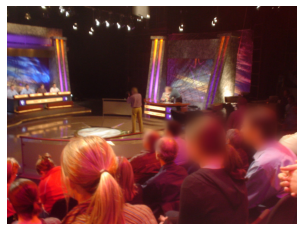

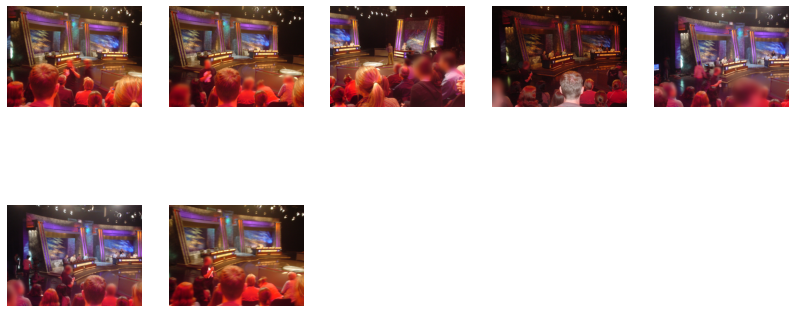

In [ ]:
index_query = 506
id_query = ids_train[index_query]
img_query = cv2.imread(os.path.join(path_data, '_'.join(id_query.split('_')[:-1]), id_query+".jpg"))
img_query = cv2.cvtColor(img_query, cv2.COLOR_BGR2RGB)

indexes_sim = match_index_lst[index_query]
id_sim = [ids_train[idx] for idx in indexes_sim]
matches_path = [os.path.join(path_data, '_'.join(id_match.split('_')[:-1]), id_match+".jpg") for id_match in id_sim]
show_imgs(img_query, matches_path)

### Gap metric

In [ ]:
def gap(pred, conf, true, return_x=False):
    """
    Compute Global Average Precision (aka micro AP), the metric for the
    Google Landmark Recognition competition.
    This function takes predictions, labels and confidence scores as vectors.
    In both predictions and ground-truth, use None/np.nan for "no label".
    Args:
        pred: vector of integer-coded predictions
        conf: vector of probability or confidence scores for pred
        true: vector of integer-coded labels for ground truth
        return_x: also return the data frame used in the calculation
    Returns:
        GAP score
    """
    x = pd.DataFrame({'pred': pred, 'conf': conf, 'true': true})
    x.sort_values('conf', ascending=False, inplace=True, na_position='last')
    x['correct'] = (x.true == x.pred).astype(int)
    x['prec_k'] = x.correct.cumsum() / (np.arange(len(x)) + 1)
    x['term'] = x.prec_k * x.correct
    gap = x.term.sum() / x.true.count()
    if return_x:
        return gap, x
    else:
        return gap

In [ ]:
# columns = 10
# rows = 4

# root_img_path = 'data/train'
# df = pd.read_csv(os.path.join(root_img_path, 'train.txt'), header=0)
# files = df['landmark_id']
# landmarkid2img_fps = dict(enumerate(files))

# # pred = pred_imgs(query, normal_ids, columns, rows)

# pred1=[]
# for i in normal_ids+2 :
#   pred1.append(landmarkid2img_fps[i-2][1])

# true1=[]
# for i in range(columns*rows):
#   true1.append(query_id)
# print(len(true1))

# gap,x =gap(pred=pred1, conf=normal_scores, true=true1, return_x=True)

In [ ]:
# gap

In [ ]:
# x

### Dùng wandb để vẽ Gap metric

In [ ]:
# wandb.log({'table':x})